# サンプリングの一般論

このノートでは、計算機によって乱数を生成する際に、知っておくべき基本事項について説明する。手法の数学的な理論に加えて、それをPythonで実装する方法も提示する。なお、本ノートの構成は [[TTH19](#TTH19)] に基づく。

全体を通して、次で読み込むライブラリを用いる。

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# グローバル変数。
rng = np.random.default_rng()  # 乱数生成器を初期化。

## 一様分布

計算機で生成できる乱数（確率変数の値）は基本的に区間 $[0, 1]$ 上の一様分布に従う確率変数 $U \sim \mathrm{Unif}([0, 1])$ のみと見做すべきである。以下で示すように、一般の分布に従う乱数は一様乱数の関数として得られる。次のプログラムはPythonで一様乱数生成する例である。

In [2]:
print(rng.uniform())                # 1つのみ生成する。
print(rng.uniform(size=10))         # 10個同時に生成することもできる。
print(rng.uniform(low=-1, high=1))  # 区間を変更する場合は最小値をlow、最大値をhighで指定する。
#print(2 * rng.uniform() - 1)        # 上の行はこの計算と同じ事をしている。勿論、ライブラリに任せた方が簡単に記述できる。

0.04650031093162177
[0.87583592 0.08942542 0.3574035  0.59197545 0.34888319 0.19620136
 0.96416497 0.90573178 0.74965792 0.6265862 ]
-0.88398629371029


一様乱数を $\mathrm{size}=100000$ 個生成した上で、ヒストグラムを描いたものが次のプログラムである。ヒストグラムは正規化している。この図より、生成した乱数は一様分布を近似的に再現することが判る。

0.9999961647221581


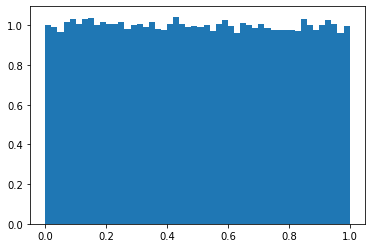

In [3]:
unif = rng.uniform(size=100000)
print(unif.max())
plt.hist(unif, bins=50, density=True, range=(0, 1))
plt.show()

ただし、計算機によって乱数を生成する上ではいくつか注意が必要である。上の例では恰も一様乱数 $U \sim \mathrm{Unif}([0, 1])$ が得られたように勘違いするが、それは次の意味で厳密には誤りである<sup>[<a href="#HN17">HN17</a>]</sup>。

- 計算機で扱える数は有限桁の2進数のみである。生成された乱数は10進小数で表されているものの、内部ではその2進展開が処理される。しかも、有限桁であるため有理数である。一般に、一様分布に従う確率変数は確率1で無理数になるため、数学的な意味での「一様乱数」とは意味が異なる。
- 計算機が生成する乱数は厳密にはランダムでない。専ら、或る決定的な数列を選び、その初項をランダムにすることによって、乱数列を生成する。この意味でしばしば**疑似乱数**という用語も使われる。例えば、代表的な疑似乱数生成のアルゴリズムに[線形合同法](https://ja.wikipedia.org/wiki/%E7%B7%9A%E5%BD%A2%E5%90%88%E5%90%8C%E6%B3%95)や[メルセンヌ・ツイスタ](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%83%AB%E3%82%BB%E3%83%B3%E3%83%8C%E3%83%BB%E3%83%84%E3%82%A4%E3%82%B9%E3%82%BF)、[Xorshift](https://ja.wikipedia.org/wiki/Xorshift)などがある。初項をランダムに与えるには、計算機の温度や生成する際の時刻などといった、環境に依存する数値が用いられる。

## 離散分布の例：Bernoulli分布および二項分布

或る閾値を $p\in [0, 1]$ とすると、一様乱数 $U \sim \mathrm{Unif}([0, 1])$ から $X \sim \mathrm{Ber}(p)$ が得られる。これは等式
$$
  \mathbb{P}(U \leq p) = p = \mathbb{P}(X = 1)
$$
が成り立つことに基づく。$p=0.5$ として、Bernoulli乱数を生成したものが次のプログラムである。

In [4]:
print(1 if rng.uniform() <= 0.5 else 0)
# これは次と等価。
#if rng.uniform() <= 0.5:
#    print(1)
#else:
#    print(0)

# また、ライブラリに用意されたメソッドのみでも書ける（Bernoulli分布は二項分布の特殊なものであることに着目）。
#print(rng.binomial(1, 0.5))

0


Bernoulli乱数を足し合わせることによって、二項分布に従う確率変数 $X \sim \mathrm{Bin}(n, p)$ が生成できる。$n=20$, $p=0.2$ として、二項乱数を生成したものが次のプログラムである。

6
[3 2 3 ... 3 5 4]


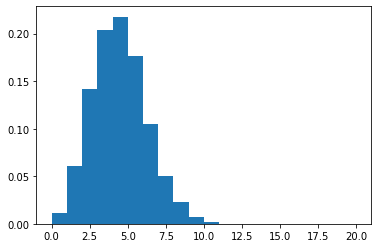

In [5]:
# 1個のみ生成。
print(np.vectorize(lambda u: 1 if u <= 0.2 else 0)(rng.uniform(size=20)).sum())
#print(rng.binomial(20, 0.2))  # ライブラリを使う場合。

# 10000個生成して、ヒストグラムを描く。
sample = np.vectorize(lambda u: 1 if u <= 0.2 else 0)(rng.uniform(size=20 * 10000)).reshape((10000, 20)).sum(axis=1)
#sample = rng.binomial(20, 0.2, 10000)  # ライブラリを使う場合。
print(sample)
plt.hist(sample, bins=20, density=True, range=(0, 20))
plt.show()

## 逆関数法

一様乱数を $U \sim \mathrm{Unif}([0, 1])$ とする。確率変数 $X$ に対して、その累積分布関数を $F_X(x) = \mathbb{P}(X \leq x)$ とする。関数 $F\colon \mathbb{R} \to [0, 1]$ の逆関数 $F_X^{-1}$ が厳密に求められるとき、
$$
  X \stackrel{\mathrm{d}}{=} F_X^{-1}(U)
$$
によって $U$ から $X$ を生成できる。

例えば、$X\sim \mathrm{Exp}(\lambda)$ のとき、指数分布の累積分布関数は
$$
  F_X(x)
  = \int_{-\infty}^{x} \lambda \mathrm{e}^{-\lambda t} \mathrm{d}t
  = 1 - \mathrm{e}^{-\lambda x}
$$
で与えられる。この逆関数は
$$
  F_X^{-1}(u) = - \frac{1}{\lambda} \log(1 - u)
$$
となる。$\lambda=1$ のときのグラフを次に示す。

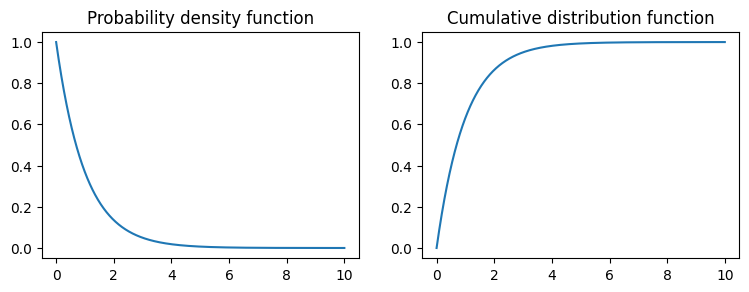

In [6]:
x = np.linspace(0, 10, 1000)
fig = plt.figure(figsize=(9, 3), dpi=100)
ax = fig.add_subplot(121)
ax.set_title("Probability density function")
ax.plot(x, np.exp(-x))
ax = fig.add_subplot(122)
ax.set_title("Cumulative distribution function")
ax.plot(x, 1 - np.exp(-x))
plt.show()

従って、逆関数法
$$
  F_X^{-1}(U) = -\frac{1}{\lambda} \log(1 - U) \stackrel{d}{=} -\frac{1}{\lambda} \log(U) \sim \mathrm{Exp}(\lambda)
$$
に基づいて、指数乱数を生成できる。実際に、乱数を生成してヒストグラムを描くプログラムを走らせると、確率密度関数 $\mathrm{d}F_X(x) / \mathrm{d}x = \mathrm{e}^{-x}$ に沿ってヒストグラムが描かれる。

1.184675287302625
[1.26754993 0.50102076 0.86781708 ... 3.04236    0.06662688 0.63422724]


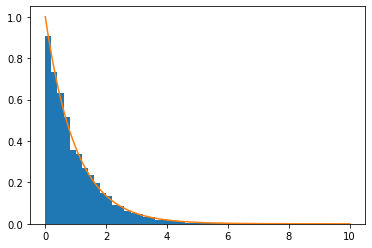

In [7]:
# 1個のみ生成。
print(-np.log(rng.uniform()))
#print(rng.exponential(1))  # ライブラリを使う場合。

# 10000個生成して、ヒストグラムを描く。
sample = -np.log(rng.uniform(size=10000))
#sample = rng.exponential(1, size=10000)  # ライブラリを使う場合。
print(sample)
plt.hist(sample, bins=50, density=True, range=(0, 10))  # ヒストグラムを描画。
x = np.linspace(0, 10, 1000)
plt.plot(x, np.exp(-x))  # 確率密度関数を描画。
plt.show()

### Box-Muller法

指数乱数に対する逆関数法を応用することによって、標準Gauss分布に従う互いに独立な確率変数 $X, Y\sim \mathrm{N}(0, 1)$ が得られる。今、互いに独立な一様乱数を $U, V\sim \mathrm{Unif}([0, 1])$ とする。
\begin{align*}
    R^2 &= -2 \log U,&
    \Theta &= 2\pi V
\end{align*}
とおけば、指数分布の累積分布関数の逆関数より $R^2 \sim \mathrm{Exp}(1 / 2)$、および $\Theta \sim \mathrm{Unif}([0, 2\pi])$ である。$R$ の確率密度関数は
\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}r} \mathbb{P}(R \leq r)
    &= \frac{\mathrm{d}}{\mathrm{d}r} \mathbb{P}(R^2 \leq r^2)\\
    &= \frac{\mathrm{d}}{\mathrm{d}r} \int_{0}^{r^2} \frac{1}{2} \mathrm{e}^{-t/2} \mathrm{d}t\\
    &= \frac{\mathrm{d}}{\mathrm{d}r} \left(1 - \mathrm{e}^{-r^2/2}\right)\\
    &= r \mathrm{e}^{-r^2/2}
\end{align*}
によって求められる。さらに、極座標変換を施して
\begin{align*}
    X &= R \cos\Theta,&
    Y &= R \sin\Theta
\end{align*}
とおく。これらの特性関数を求めることによって、$(X, Y)$ が独立な標準Gauss分布に従うことが示せる。以上のように、一様乱数をGauss乱数に変換する手法を[Box-Muller法](https://ja.wikipedia.org/wiki/%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%EF%BC%9D%E3%83%9F%E3%83%A5%E3%83%A9%E3%83%BC%E6%B3%95)という。

0.41822391666645187
[-0.08546811 -0.95669319  0.69867201 ... -1.12497271 -0.70435124
 -0.48431908]


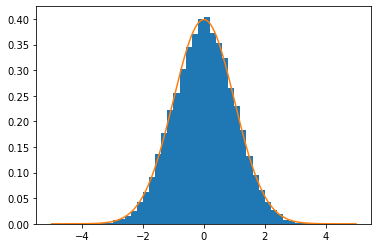

In [8]:
# 1個のみ生成。
print(np.sqrt(-2 * np.log(rng.uniform())) * np.cos(rng.uniform(0, 2 * np.pi)))
#print(rng.normal())  # ライブラリを使う場合。

# 10000個生成して、ヒストグラムを描く。
sample = np.sqrt(-2 * np.log(rng.uniform(size=10000))) * np.cos(rng.uniform(low=0, high=2 * np.pi, size=10000))
#sample = rng.normal(size=10000)  # ライブラリを使う場合。
print(sample)
plt.hist(sample, bins=50, density=True, range=(-5, 5))   # ヒストグラムを描画。
x = np.linspace(-5, 5, 1000)
plt.plot(x, np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi))  # 確率密度関数を描画。
plt.show()

### 補足：中心極限定理に基づく方法

Gauss分布に限れば、[中心極限定理](https://ja.wikipedia.org/wiki/%E4%B8%AD%E5%BF%83%E6%A5%B5%E9%99%90%E5%AE%9A%E7%90%86)に基づいてGauss乱数を生成することもできる。即ち、独立同分布な一様乱数の列 $\{U_i\}_{i=1}^\infty$, $U_1 \sim \mathrm{Unif}([-1, 1])$ に対して、
$$
    \mathbb{P}\biggl(a \leq \frac{\sqrt{3}}{\sqrt{n}} \sum_{i=1}^{n} U_i \leq b\biggr)
    \xrightarrow[n\to\infty]{}
    \frac{1}{\sqrt{2\pi}} \int_{a}^{b} \mathrm{e}^{-x^2 / 2} \mathrm{d}x
$$
が成り立つことを用いる。

-0.39649882858307633
[ 1.26202303  0.90593644 -0.08929267 ... -0.75305727 -0.4699968
 -0.36177555]


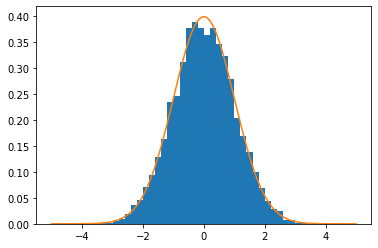

In [9]:
# 1個のみ生成。
print(rng.uniform(-1, 1, 9).sum() / np.sqrt(3))  # n=9 程度でも十分。

# 10000個生成して、ヒストグラムを描く。
sample = rng.uniform(low=-1, high=1, size=10000 * 9).reshape((10000, 9)).sum(axis=1) / np.sqrt(3)
print(sample)
plt.hist(sample, bins=50, density=True, range=(-5, 5))   # ヒストグラムを描画。
x = np.linspace(-5, 5, 1000)
plt.plot(x, np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi))  # 確率密度関数を描画。
plt.show()

## 棄却サンプリング

逆関数法では累積分布関数の逆関数が厳密に求められることが要求されていたため、一般の確率分布に対するサンプリングに適用することができない。一般の場合でも使える手法の一つに[棄却サンプリング](https://en.wikipedia.org/wiki/Rejection_sampling) (rejection sampling) がある。今、サンプリングしたい分布 $F$ の確率密度関数を $f\colon \mathbb{R} \to [0, 1]$ とする。既知の分布 $G$（一様分布から逆関数法などによって得られる確率分布という意味）の確率密度関数 $g\colon \mathbb{R} \to [0, 1]$ に対して、
$$
    \exists M > 0 \quad\text{s.t.}\quad \forall y\in\mathbb{R},\ M g(y) \geq f(y)
$$
が満たされるとする。このとき、次のアルゴリズムによって $f$ の確率分布に従う確率変数を生成できる：

1. 乱数 $Y \sim G$ と $U \sim \mathrm{Unif}([0, 1])$ とを生成する。
1. 不等式 $U \leq f(Y) / (M g(Y))$ を判定する。
    - もし不等式が真ならば、提案された乱数 $Y$ が分布 $F$ に従っていると見なして受理する。
    - もし不等式が偽ならば、提案された乱数 $Y$ を棄却する。

ここでは例として、[Laplace分布](https://en.wikipedia.org/wiki/Laplace_distribution) $\mathrm{Laplace}(0, 1)$ から標準Gauss分布 $\mathrm{N}(0, 1)$ を生成しよう。$M=\sqrt{2}$ に取れば、不等式
$$
    %\sqrt{3} \cdot \frac{\mathrm{e}^{-\sqrt{2} \lvert y\rvert}}{\sqrt{2}} \geq \frac{\mathrm{e}^{-y^2 / 2}}{\sqrt{2\pi}}  % b = 1 / \sqrt{2}, M = \sqrt{3}
    \sqrt{2} \cdot \frac{\mathrm{e}^{-\lvert y\rvert}}{2} \geq \frac{\mathrm{e}^{-y^2 / 2}}{\sqrt{2\pi}}
$$
が全ての $x\in\mathbb{R}$ に対して成り立つ。また、Laplace乱数自体は、互いに独立な一様乱数 $U, V \sim \mathrm{Unif}([0, 1])$ から $\log(U / V)$ によって生成できる。

Accepted rate = 0.70811
[ 0.06455855  0.81870397  0.4320602  ...  0.32876673  0.71997995
 -0.92309808]


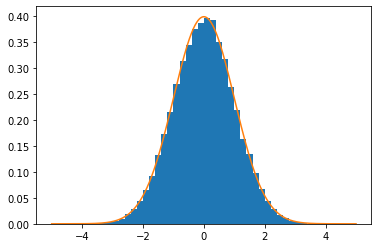

In [10]:
# 100000回試行して、ヒストグラムを描く。
sample = np.log(rng.uniform(size=100000) / rng.uniform(size=100000))
unif = rng.uniform(size=100000)
sample = sample[unif * np.exp(-np.abs(sample)) <= np.exp(-0.5 * sample ** 2) / np.sqrt(np.pi)]
print('Accepted rate =', sample.size / 100000)
print(sample)
plt.hist(sample, bins=50, density=True, range=(-5, 5))   # ヒストグラムを描画。
x = np.linspace(-5, 5, 1000)
plt.plot(x, np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi))  # 確率密度関数を描画。
plt.show()

ただし、棄却サンプリングには次のような弱点がある。

- サンプリングしたい確率分布 $F$ に**近い**提案分布 $G$ を人為的に求める必要がある。もし余り良くない提案分布を取ると、試行した殆どの乱数が棄却されてしまう恐れがある。例えば、提案分布 $G$ の定数倍でサンプリングしたい確率分布 $F$ を覆うために非常に巨大な $M$ が必要になったとしよう。このとき、$f(Y) / (M g(Y)) \ll 1$ となるから、試行した殆どの乱数が棄却されてしまう。
- 状態空間が非常に大きい場合は特に注意が必要である。例えば、半径が$1$ の $d$ 次元球の内部に一様分布する乱数をサンプリングすることを考えよう。提案分布として、一辺が $1$ の $d$ 次元超立方体内の一様分布を選ぶと、これらの体積比は
$$
    \frac{\text{Volume of sphere}}{\text{Volume of cube}} = \frac{\pi^{d/2} / \Gamma(d / 2 + 1)}{1} \xrightarrow[d\to\infty]{} 0
$$
であるので、$d$ が大きくなるほど棄却される乱数が増加してゆく。この意味で、棄却サンプリングは[次元の呪い](https://ja.wikipedia.org/wiki/%E6%AC%A1%E5%85%83%E3%81%AE%E5%91%AA%E3%81%84)の影響を受けやすい。

なお、棄却サンプリングに対し、サンプリングしたい分布 $F$ の確率が高いところのみを得られれば十分であるとする考え方もある。これを[重点サンプリング](https://en.wikipedia.org/wiki/Importance_sampling) (importance sampling) という。重点サンプリングは確率変数の関数の期待値（積分値）を計算するときに有効である。

## Metropolis-Hastings法

Markov Chain Monte Carlo法 (MCMC) と呼ばれる、Markov連鎖が定常分布に収束することを利用したアルゴリズムの一種である。サンプリングしたい分布 $F$ の確率密度関数を $f\colon \mathbb{R} \to [0, 1]$ とする。棄却サンプリングのときと同様に提案分布 $G_x$ を定める。ただし、任意の状態 $x\in\mathbb{R}$ に対して、$G_x$ は $x$ で条件付けられた確率で与えられるとする。また、$G_x$ の確率密度関数 $g(x, \cdot)\colon \mathbb{R} \to [0, 1]$ は対称であることを要請する。これらを式で表すと

- $\forall x \in \mathbb{R}$, $\int_{\mathbb{R}} g(x, y) \mathrm{d}y=1$,
- $\forall x, y \in \mathbb{R}$, $g(x, y) = g(y, x)$

となる。これらの $f$ と $g$ を用いて、Markov連鎖 $\{X_t\}_{t=0}^{\infty}$ を構成するのが次の[Metropolis-Hastings法](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%83%88%E3%83%AD%E3%83%9D%E3%83%AA%E3%82%B9%E3%83%BB%E3%83%98%E3%82%A4%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%82%B9%E6%B3%95)である。

1. 初期状態 $X_0$ を定める。
1. $t$ ステップ目に於て、
    1. 候補 $Y \sim G_{X_t}$ を生成する。
    1. 採択率 $\alpha = f(Y) / f(X_t)$ を計算する。
    1. もし $\alpha \geq 1$ ならば、$Y$ を受理して $X_{t+1} = Y$ とする。
    1. もし $\alpha < 1$ ならば、一様乱数 $U \sim \mathrm{Unif}([0, 1])$ を生成する。
        - もし $U \leq \alpha$ ならば、$Y$ を受理して $X_{t+1} = Y$ とする。
        - もし $U > \alpha$ ならば、$Y$ を棄却して $X_{t+1} = X_t$ とする。
1. 以上の操作を十分大きな $t$ まで続ける。

上記のアルゴリズムを遷移確率密度関数 $P\colon \mathbb{R}^2 \to [0, 1]$ で表せば
$$
    P(x, y) = g(x, y) \min\biggl\{1, \frac{f(y)}{f(x)}\bigg\}
$$
となる。$P(x, y) \mathrm{d}y$ と書いたとき、これは状態 $x$ から状態 $y$ への遷移確率を意味する。上式の定義より、$f$ と $P$ に対して詳細釣合いの条件
$$
    f(x) P(x, y) = f(y) P(y, x)
    \quad\left(
    \stackrel{\text{対称性}}{\iff}
    f(x) g(x, y) P(x, y) = f(y) g(y, x) P(y, x)
    \right)
$$
が満たされることに注意されたい。そのため、Markov連鎖 $\{X_t\}_{t=0}^{\infty}$ は $f$ を定常分布として持つ。即ち、初期分布を $\nu(A) = \mathbb{P}(X_0 \in A)$ ($A\in\mathcal{B}(\mathbb{R})$) とすると、任意の $B\in\mathcal{B}(\mathbb{R})$ に対して、
$$
    \int_{B} \mathrm{d}x \int_{\mathbb{R}} \nu(\mathrm{d}y) (P)^{* t}(y, x) = \int_{B} \mathrm{d}x \int_{\mathbb{R}} \nu(\mathrm{d}y) (\underbrace{P * \dots * P}_{t\text{-fold}})(y, x)
    \xrightarrow[t\to\infty]{} \int_{B} f(x) \mathrm{d}x
$$
が成り立つ。

例として、[ロジスティック分布](https://en.wikipedia.org/wiki/Logistic_distribution)から標準Gauss分布を生成しよう。初期値を $X_0 = 0$、および $t$ ステップ目の状態を $x$ としたとき、提案分布を $\mathrm{Logistic}(x, \sqrt{3}/\pi)$ とする。逆関数法より、ロジスティック乱数は一様乱数 $U\sim \mathrm{Unif}([0, 1])$ から $x + \sqrt{3} (\log U - \log(1 - U)) / \pi$ によって生成できる。定常分布が $\mathrm{N}(0, 1)$ だから、遷移確率密度関数は
$$
    P(x, y) = \frac{\pi \mathrm{e}^{-\sqrt{3} (y - x) / \pi}}{\sqrt{3} (1 + \mathrm{e}^{-\sqrt{3} (y - x) / \pi})^2} \cdot \min\bigl\{1, \mathrm{e}^{-(y^2 - x^2) / 2}\big\}
$$
となる。

[ 0.          0.         -0.08833534 ... -1.55891813 -0.07969768
 -1.40284564]


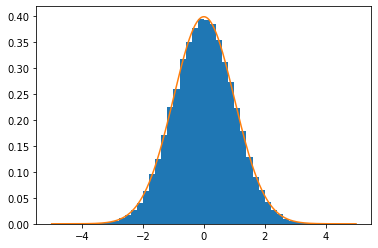

In [11]:
# 100000回試行して、ヒストグラムを描く。
sample = np.empty(100000 + 1, dtype=float)
sample[0] = 0.e0  # 初期値を0とする。
unif = rng.uniform(size=100000)
for t in range(100000):
    proposal = sample[t] + np.sqrt(3) * (np.log(unif[t]) - np.log(1 - unif[t])) / np.pi
    #proposal = sample[t] + rng.logistic(0, np.sqrt(3) / np.pi)  # ライブラリを使う場合
    accepted = np.exp(-0.5 * (proposal ** 2 - sample[t] ** 2))
    if accepted >= 1.e0:
        sample[t + 1] = proposal
    elif rng.uniform() <= accepted:
        sample[t + 1] = proposal
    else:
        sample[t + 1] = sample[t]
print(sample)
plt.hist(sample, bins=50, density=True, range=(-5, 5))   # ヒストグラムを描画。
x = np.linspace(-5, 5, 1000)
plt.plot(x, np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi))  # 確率密度関数を描画。
plt.show()

Metropolis-Hastings法は棄却サンプリングに比べると次のような長所がある。

- 実際に計算するのは比 $f(Y) / f(X_t)$ のみだから、サンプリングしたい分布の確率密度関数 $f$ は比例関係 $\propto$ さえ解っていれば良い。
- サンプリングしたい分布 $F$ を提案分布 $G$ で覆う必要が無いので、棄却サンプリングよりも比較的簡単に提案分布を選べる。ただし、分散が大き過ぎると適切な場所から離れてしまい、小さ過ぎると収束までに時間が掛かってしまう。その点には注意する必要がある。

しかし、一方で次のような短所もある。

- Markov連鎖が収束するまでに十分永い時間を掛ける必要がある（Markov連鎖の収束定理<sup>[<a href="#LP17">LP17</a>]</sup>によって指数関数的に収束すると思うかもしれないが、指数関数に掛けられる定数が巨大に、あるいは指数関数の肩の定数が非常に小さくなる場合には、現実的な時間でないことも有り得る）。必要な時間は混合時間を評価することで判るものの、一般にその評価を与えるのは易しくない。
- 実際の数値計算に於ては有限時間で計算を打ち切る必要があるため、初期値依存性にも気を配る必要がある。
- サンプリングしたい分布の密度関数 $f$ に局所最大値が多く含まれていると、それらの点の周りに留まり易くなる。その結果、状態空間の点を満遍なくサンプリングするまでに時間が掛かる。

## Gibbs sampler

（加筆予定）

## 参考文献および注釈

<dl>
  <dt id="HN17">[HN17]</dt>
  <dd>O. Haggstrom 著、野間口謙太郎 訳『やさしいMCMC入門――有限マルコフ連鎖とアルゴリズム――』（共立出版、2017年）</dd>

  <dt id="LP17">[LP17]</dt>
  <dd>D.A. Levin and Y. Peres. <i>Markov chains and mixing times</i>, second ed. Vol. 107. American Mathematical Soc., 2017.</dd>

  <dt id="TTH19">[TTH19]</dt>
  <dd>田中章詞、富谷昭夫、橋本幸士『ディープラーニングと物理学&emsp;原理がわかる、応用ができる』（講談社、2019年）</dd>
</dl>